<a href="https://colab.research.google.com/github/lschmiddey/Price-Finding/blob/master/dynamicpricing_avocados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a blue print how one could estimate different demand functions from data and then use the succeeding data to update information on how to set the optimal price.

The data is taken from: https://www.kaggle.com/neuromusic/avocado-prices

In [79]:
import os
import random
import pandas as pd
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import leastsq
from scipy.optimize import minimize, Bounds
from scipy.optimize import minimize_scalar
from sklearn import preprocessing
data = pd.read_csv('sample_data/avocado.csv')

In [8]:
# Constants
TEST_PERC = 0.1
SAMPLE_PERC = 0.2

In [165]:
data.head(2)

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany


In [166]:
data.region.unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [179]:
regions = ['California', 'SanDiego', 'SanFrancisco', 'PhoenixTucson']
complete_conv_data = data[(data['type'] == 'conventional') & (data['region'].isin(regions))]
conv_data = data[(data['type'] == 'conventional') & (data['region'] == 'California')]
org_data = data[(data['type'] == 'organic') & (data['region'] == 'California')]

To make the volume comparable between the regions we use the min_max scaling grouped by each region.

In [180]:
complete_conv_data['Normalised_Volume'] = complete_conv_data.groupby('region')['Total Volume'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
conv_data['Normalised_Volume'] = conv_data.groupby('region')['Total Volume'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
org_data['Normalised_Volume'] = org_data.groupby('region')['Total Volume'].apply(lambda x: (x-x.min())/(x.max()-x.min()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

We want to order by date and take the last 10% of the dataset as testset

In [181]:
len_complete_data_conv = complete_conv_data.shape[0]
len_data_conv = conv_data.shape[0]
len_data_org = org_data.shape[0]

In [190]:
train_conv_complete = complete_conv_data.sort_values(by='Date').iloc[:-round(len_complete_data_conv*TEST_PERC),:]
train_conv = conv_data.sort_values(by='Date').iloc[:-round(len_data_conv*TEST_PERC),:]
test_conv_complete = complete_conv_data.sort_values(by='Date').iloc[-round(len_complete_data_conv*TEST_PERC):,:]
test_conv = conv_data.sort_values(by='Date').iloc[-round(len_data_conv*TEST_PERC):,:]

train_org = org_data.sort_values(by='Date').iloc[:-round(len_data_org*TEST_PERC),:]
test_org = org_data.sort_values(by='Date').iloc[-round(len_data_org*TEST_PERC):,:]

In [191]:
train_conv_complete.head(2)

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Normalised_Volume
2183,51,2015-01-04,0.94,461607.33,244152.26,165299.33,15302.75,36852.99,30884.29,5595.0,373.7,conventional,2015,SanDiego,0.294820
1767,51,2015-01-04,0.65,1048062.16,770635.37,178418.32,6509.41,92499.06,92499.06,0.0,0.0,conventional,2015,PhoenixTucson,0.259278


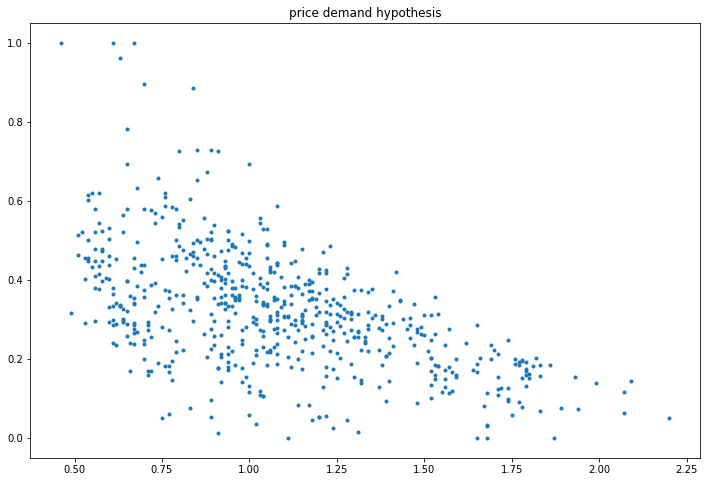

In [192]:
plt.plot(train_conv_complete.AveragePrice, train_conv_complete['Normalised_Volume'], '.')
plt.title("price demand hypothesis")
plt.show()

Globally define parametric function and how we want to minimize it.

In [193]:
  # Standard Form of log-lin function
  def func_(params, x):
    a, b = params
    return np.exp(a + b * x)


  # Error function, that is, the difference between the value obtained by fitting curve and the actual value
  def error_func(params, x, y):
    return func_(params, x) - y

In [194]:
class log_lin_candidates:
  def __init__(self, len_data, sample_perc, train_data, no_candidates=5):
        self.len_data=len_data
        self.sample_perc=sample_perc
        self.no_candidates=no_candidates
        self.train_data=train_data

  def sample_for_candidates(self, no_candidates):
    sample_list=[]
    for i in range(0,no_candidates):
      rnd_seed = random.randint(0,2000) # random_seed
      # Data to be fitted
      X = self.train_data.AveragePrice.sample(n=round(self.len_data*self.sample_perc), random_state=rnd_seed).values
      Y = self.train_data['Normalised_Volume'].sample(n=round(self.len_data*self.sample_perc), random_state=rnd_seed).values
      sample_list.append((X,Y))
    return sample_list

  # Solving parameters
  def slovePara(self):

    p0 = [10, 10]
    para_list=[]

    samples_list = self.sample_for_candidates(self.no_candidates)

    for i in range(0,self.no_candidates):
      X = samples_list[i][0]
      Y = samples_list[i][1]
      Para = leastsq(error_func, p0, args=(X, Y))
      para_list.append(Para[0])
    return para_list

  # Output the final result
  def solution(self):
    Para = self.slovePara()
    #print( "a=",a," b=",b)
    #print( "cost:" + str(Para[1]))
    #print ("The curve of solution is:")
    #print(f'y=exp{a}+{b} * x')

    return Para




In [195]:
p=log_lin_candidates(len_data=len_data_conv, sample_perc=SAMPLE_PERC, train_data=train_conv_complete)
Para = p.solution()

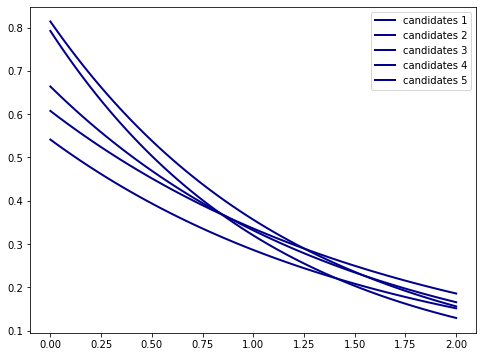

In [196]:
plt.figure(figsize=(8,6))
x = np. linspace (0, 2, 100) # draw 100 continuous points directly from 0 to 2

for i in range(0,len(Para)):
  a=Para[i][0]
  b=Para[i][1]
  # Drawing Fitted Lines
  y = np.exp(a + b*x) # # function
  plt.plot(x,y,color="darkblue",label=f'candidates {i+1}',linewidth=2)
plt.legend ()# Draw Legend
plt.show()

# Simulation

We take the price and quantity from the succeding dates to find the optimal price-function and thereby calculate the optimal price.

In [197]:
test_conv_complete.shape

(68, 15)

In [198]:
class PriceFinding:
    def __init__(self, test_data, params, T=17, m=1, min_price=0.5, max_price=2.5):
        self.test_data=test_data
        self.params=params
        self.T=T
        self.m=m
        self.min_price=min_price
        self.max_price=max_price
        

    def log_linear_function_demand_(self,x,a,b):
        return -(x * (np.exp(a + b * x)))
    
    def calc_demand(self, p):
        list_demand=[]
        def log_linear_function_demand(x,a,b):
            return -(x * (np.exp(a + b * x)))
        for i in range(0, len(self.params)):
                a=self.params[i][0]
                b=self.params[i][1]
                temp_demand = -log_linear_function_demand(p,a,b)
                list_demand.append(temp_demand)
        return list_demand
    
    def calc_opt_p(self):
        list_p_opt=[]
        def log_linear_function_demand(x):
            return -(x * (np.exp(a + b * x)))
        for i in range(0, len(self.params)):
                a=self.params[i][0]
                b=self.params[i][1]
                res = minimize_scalar(log_linear_function_demand, method='bounded', bounds=(self.min_price, self.max_price))
                list_p_opt.append(res['x'])
        return list_p_opt 

    
    def make_mask(self):
        t_mask = np.array(range(0,round(self.T/self.m)))
        t_mask = np.repeat(t_mask, self.m)
        
        return t_mask
        
    def run_simulation(self):
        T = self.T                          # time step is month
        m = self.m                            # every 3 days

        tau = 0                                 # start time of the current interval

        t_mask = self.make_mask()
        
        hist_d = []
        
        price_trace_opt=[]
        price_trace_real=[]

        for t in range(0, T - 1):               # simulation loop
            realized_d = self.test_data.iloc[t,-1]

            hist_d.append(realized_d)
            p = self.test_data.iloc[t,2]
            price_trace_real.append(p)
            


            if( t_mask[t] != t_mask[t + 1] ):   # end of the interval
                interval_mean_d = np.mean( hist_d[tau : t + 1] )

                min_dist = float("inf")
                dist_hypothesis=[]
                index_price_hypothesis=[]

                demand_pred_by_func = self.calc_demand(p)
                for demand in demand_pred_by_func:
                    dist = abs(interval_mean_d - demand)
                    dist_hypothesis.append(dist)
                idx_price = np.argmin(dist_hypothesis)

                
                p_opt = self.calc_opt_p()[idx_price]             # set price for the next interval
                price_trace_opt.append(p_opt)
                tau = t + 1  
                
        return price_trace_real, price_trace_opt
    
    def make_plt(self, real_price=True):
        
        price_trace_real, price_trace_opt = self.run_simulation()
        if real_price:
          y = np.asarray(price_trace_real)
        else:
          y = np.asarray(price_trace_opt)

        x = range(0,len(y))
        
        plt.figure(figsize=(12,8)) # In this example, all the plots will be in one figure.    
        for i in range(len(self.calc_opt_p())):
            plt.plot(x, y, '-', label='Estimate')
        plt.title("price finding")
        xcoords = np.arange(0,stop=self.T, step=self.m)
        for xc in xcoords:
            plt.axvline(x=xc)
        plt.grid()
        plt.ylim(0, 2.5)
        plt.show()

In [199]:
p=PriceFinding(test_data=test_conv_complete, params=Para)

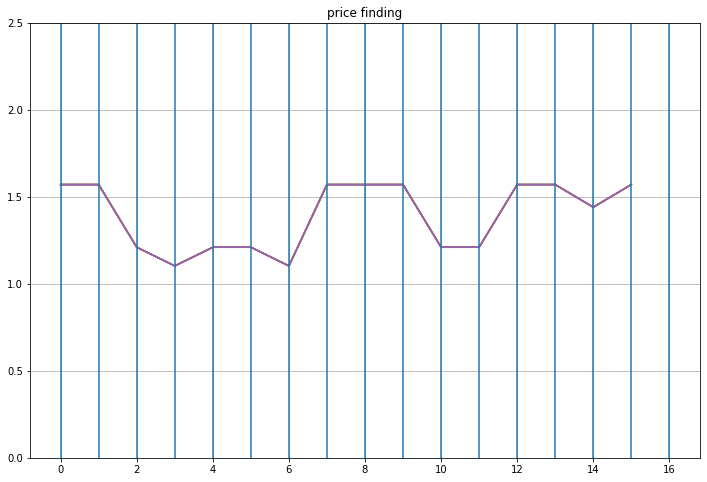

In [200]:
p.make_plt(real_price=False)

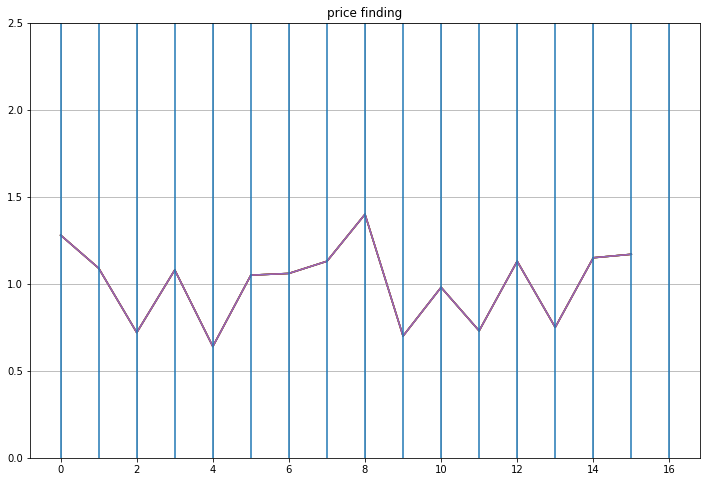

In [201]:
p.make_plt(real_price=True)

When we take the functional log-lin form as a suitable parametric function for the damend-function, we see that the real avocado price is a bit to low. However, this simulation is in a way flawed, because we rarely see these high prices in action. In production, we would set the price to be the one given as optimal from our best candidate and than observe the price demand tuple. Here, we take the next real price and observed demand and then update the best candidate function.